_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student name: FILL IN YOUR NAMES HERE

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-22 14:28:01Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

sklearn: 1.4.2

matplotlib: 3.8.4
seaborn   : 0.13.2
pandas    : 2.2.2
numpy     : 1.26.4
scipy     : 1.13.0

Watermark: 2.4.3



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [4]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [5]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 0: Resampling

In [6]:
# set resampling factor 100 /25 = 4
q = 4

print(
    "shapes before resampling:",
    ogb_calcium.shape,
    ogb_spikes.shape,
    gcamp_calcium.shape,
    gcamp_spikes.shape,
)


def resample(x: pd.DataFrame, q: int, use_scipy=True) -> pd.DataFrame:
    """
    Resamples the input DataFrame by using SciPy's decimate function or summing over non-overlapping blocks of rows.

    Parameters:
    - x: pd.DataFrame
        The input DataFrame with spike signals in each column.
    - q: int
        The downsampling factor. The number of rows in the output will be the original number of rows divided by this factor.
    - use_scipy: bool, default=True
        If True, uses SciPy's decimate function to downsample the DataFrame. If False, sums over non-overlapping blocks of size `q`.

    Returns:
    - pd.DataFrame
        The resampled DataFrame.
    """
    if use_scipy:
        return pd.DataFrame(
            signal.decimate(x, q=q, axis=0),
            columns=np.arange(0, x.shape[1]).astype("str"),
        )
    else:
        # trim to a multiple of the factor q
        n = x.shape[0]
        m = n // q
        x.drop(x.tail(n - (m * q)).index, inplace=True)

        # put every entry into non-overlapping bins
        x["bin"] = np.arange(0, m).repeat(q)

        # sum over the bins
        resampled_x = x.groupby(["bin"]).sum()

        return resampled_x


# resample the calcium signal with scipy.signal.decimate
ogb_calcium_25 = resample(ogb_calcium, q=q)
gcamp_calcium_25 = resample(gcamp_calcium, q=q)

# resample the spike signal, that does not work with the scipy function, because it is a int signal
ogb_spikes_25 = resample(ogb_spikes, q=q, use_scipy=False)
gcamp_spikes_25 = resample(gcamp_spikes, q=q, use_scipy=False)

print(
    "shapes after resampling:",
    ogb_calcium_25.shape,
    ogb_spikes_25.shape,
    gcamp_calcium_25.shape,
    gcamp_spikes_25.shape,
)

shapes before resampling: (71986, 11) (71986, 11) (23973, 37) (23973, 37)
shapes after resampling: (17997, 11) (17996, 11) (5994, 37) (5993, 37)


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

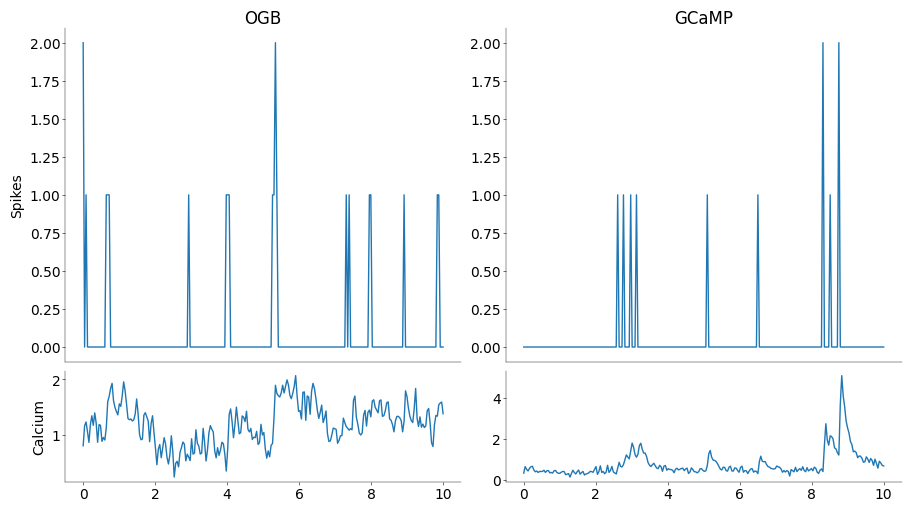

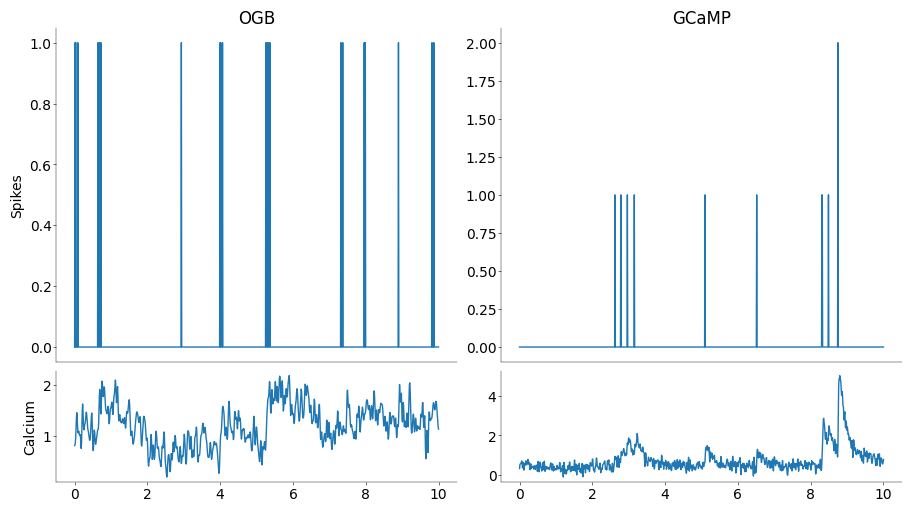

In [65]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------
SHOWPRERESAMPLED = True

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

# set sampling rate in Hz
fs = 25

# set time-window in s
start = 0
duration = 10
end = start + duration

# convert timewindow to samples
start_s = start * fs
duration_s = duration * fs
end_s = end * fs

# create time linspace
time = np.linspace(start, end, duration_s)

# plot raw ogb data of Cell 5
axs[0, 0].plot(time, ogb_spikes_25["5"][start_s:end_s])
axs[1, 0].plot(time, ogb_calcium_25["5"][start_s:end_s])

# plot raw gcamp data of cell 6
axs[0, 1].plot(time, gcamp_spikes_25["6"][start_s:end_s])
axs[1, 1].plot(time, gcamp_calcium_25["6"][start_s:end_s])

# first row does not need x-axis
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])

# set the column names for the subplots
axs[0, 0].set_title("OGB")
axs[0, 1].set_title("GCaMP")

# set the row names for the subplots
axs[0, 0].set_ylabel("Spikes")
axs[1, 0].set_ylabel("Calcium")

plt.show()

if SHOWPRERESAMPLED:
    fig, axs = plt.subplots(
        2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
    )

    # set sampling rate in Hz
    fs = 100

    # set time-window in s
    start = 0
    duration = 10
    end = start + duration

    # convert timewindow to samples
    start_s = start * fs
    duration_s = duration * fs
    end_s = end * fs

    # create time linspace
    time = np.linspace(start, end, duration_s)

    # plot raw ogb data of Cell 5
    axs[0, 0].plot(time, ogb_spikes["5"][start_s:end_s])
    axs[1, 0].plot(time, ogb_calcium["5"][start_s:end_s])

    # plot raw gcamp data of cell 6
    axs[0, 1].plot(time, gcamp_spikes["6"][start_s:end_s])
    axs[1, 1].plot(time, gcamp_calcium["6"][start_s:end_s])

    # first row does not need x-axis
    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])

    # set the column names for the subplots
    axs[0, 0].set_title("OGB")
    axs[0, 1].set_title("GCaMP")

    # set the row names for the subplots
    axs[0, 0].set_ylabel("Spikes")
    axs[1, 0].set_ylabel("Calcium")

    plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


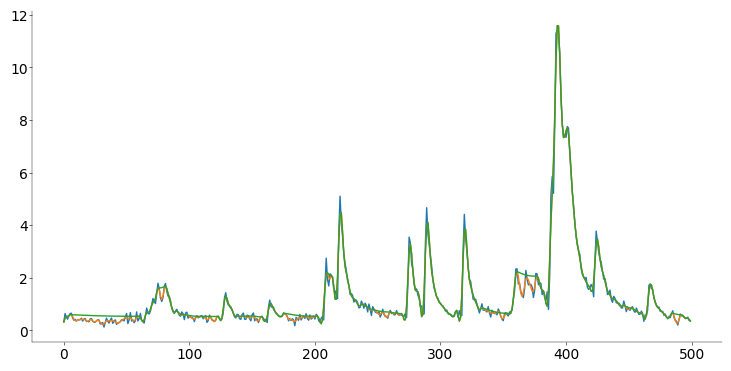

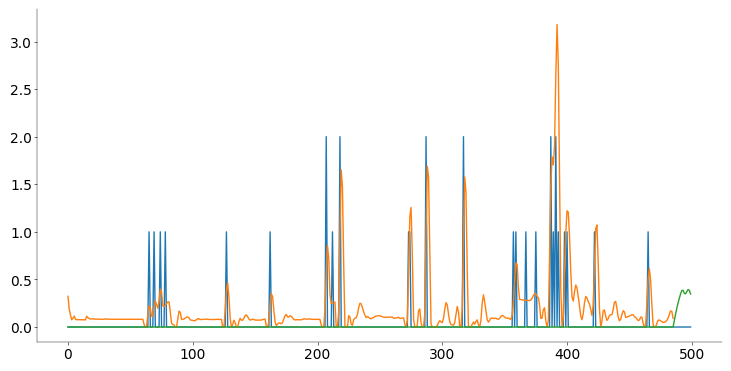

In [116]:
def butterworth_lowpass_filter(
    data: np.ndarray, cutoff: float, fs: float, order: int = 4
) -> np.ndarray:
    """
    Apply a 4-pole Butterworth lowpass filter to the input data with a specified cutoff frequency.

    Parameters
    ----------
    data : np.ndarray, (n_points,)
        The input signal to be filtered.

    cutoff : float
        The cutoff frequency of the filter in Hz.

    fs : float
        The sampling frequency of the input signal in Hz.

    order : int, optional
        The order of the filter. Default is 4 (4-pole).

    Returns
    -------
    np.ndarray
        The filtered signal.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist

    sos = signal.butter(order, normal_cutoff, btype="low", analog=False, output="sos")
    filtered_data = signal.sosfiltfilt(sos, data)

    return filtered_data


def iterative_smoothing(data, thrnoise=1, max_iter=5000):
    """
    Apply iterative smoothing to a signal.

    This function applies an iterative smoothing procedure to a 1-dimensional signal.
    It identifies peaks in the signal and smooths the segments between adjacent peaks
    with amplitudes smaller than the specified threshold. The smoothing is repeated
    iteratively until a stopping condition is met.

    Parameters
    ----------
    data : array_like
        The 1-dimensional input signal.
    thrnoise : float, optional
        The threshold amplitude below which smoothing is applied. Defaults to 1.
    max_iter : int, optional
        The maximum number of iterations. Defaults to 5000.

    Returns
    -------
    array_like
        The smoothed signal.

    Notes
    -----
    - This function does not modify the input signal.
    - The iterative smoothing continues until all peaks with amplitudes less than
      the threshold are removed, or until the maximum number of iterations is reached.
    """
    # Make a copy of the input signal to avoid modifying it in place
    smoothed_signal = data.copy()

    for iteration in range(max_iter):
        # Find all peaks in the signal
        peaks, _ = signal.find_peaks(smoothed_signal)

        # Check if there are enough peaks to continue
        if len(peaks) < 2:
            break

        # Calculate peak-to-peak amplitudes
        peak_amplitudes = np.abs(np.diff(smoothed_signal[peaks]))

        # Identify the smallest peak amplitude
        if len(peak_amplitudes) == 0:
            break
        pmin_idx = np.argmin(peak_amplitudes)
        pmin = peaks[pmin_idx]

        # Check if the smallest peak amplitude is below the threshold
        if peak_amplitudes[pmin_idx] < thrnoise:
            # Define the segment between the adjacent peaks of pmin
            segment_start = peaks[pmin_idx]
            segment_end = peaks[pmin_idx + 1]
            segment = smoothed_signal[segment_start : segment_end + 1]

            # Apply smoothing three times
            for _ in range(3):
                # Calculate the average of each point with its neighbors
                smoothed_segment = segment.copy()
                for i in range(1, len(segment) - 1):
                    smoothed_segment[i] = np.sum(segment[i - 1 : i + 2]) / 3
                segment = smoothed_segment

            # Replace the original segment with the smoothed segment
            smoothed_signal[segment_start : segment_end + 1] = segment
        else:
            # Stop if no peak satisfies the threshold condition
            break

    return smoothed_signal


def kernel(t: np.ndarray, tau: float) -> np.ndarray:
    """
    Compute the exponential decay kernel.

    This function takes a numpy array of time values and a decay constant,
    and returns the exponential decay kernel for those time values.

    Parameters
    ----------
    t : np.ndarray
        A numpy array of time values.

    tau : float
        The decay constant.

    Returns
    -------
    np.ndarray
        A numpy array containing the computed exponential decay values.

    Raises
    ------
    ValueError
        If tau is zero.
    """
    if tau == 0:
        raise ValueError("tau must be non-zero")

    return np.exp(-t / tau)


def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """
    Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    deconvolved_ca: np.array (n_points,)
        spiking rate of the signal
    """

    # insert your code here

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    # procedure follows Yaksi & Friedrich 2006
    # 1. low pass filter
    # set cutoff frequency to 0.2*25 = 5 as in the paper
    cutoff_freq = 5  # Hz
    plt.plot(ca[:dt])
    filtered_ca = butterworth_lowpass_filter(ca[:dt], cutoff_freq, fs=25, order=4)
    plt.plot(filtered_ca)

    # 2. Apply iterative average smoothing
    smoothed_ca = iterative_smoothing(filtered_ca, thrnoise=0.3, max_iter=1000000000)
    plt.plot(smoothed_ca)
    plt.show("Smoothing process")

    # 3. deconvolve
    # create kernel
    kernel_ca = kernel(np.linspace(0, 2 * tau, int(50 * tau)), tau)

    deconvolved_ca, remainder = signal.deconvolve(smoothed_ca, kernel_ca)
    # apply heavyside function
    deconvolved_ca[deconvolved_ca < 0] = 0

    return deconvolved_ca, remainder


deconvolved_ca, remainder = deconv_ca(gcamp_calcium_25["6"], 0.3, 500)

plt.plot(gcamp_spikes_25["6"][:500])
plt.plot(deconvolved_ca)
plt.plot(remainder)
plt.show()

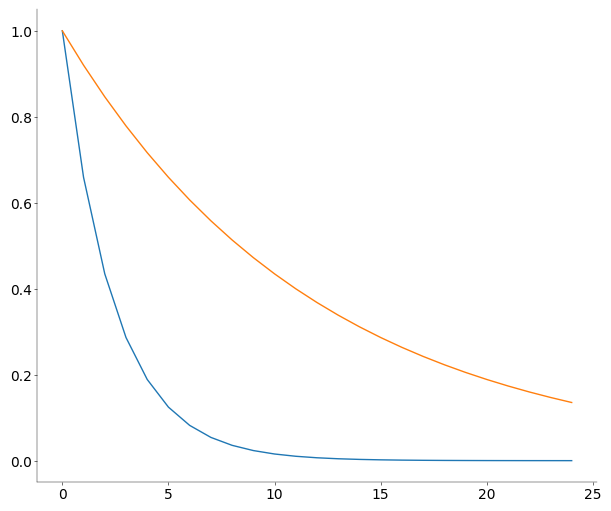

In [59]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
ax.plot(kernel(np.linspace(0, 1, 25), 0.1))
ax.plot(kernel(np.linspace(0, 1, 25), 0.5))
plt.show()

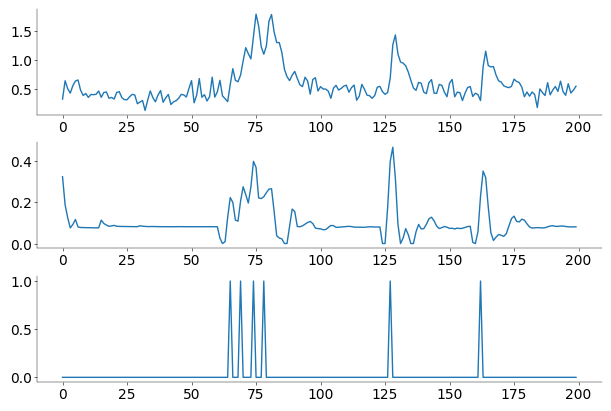

In [117]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

axs[0].plot(gcamp_calcium_25["6"][:200])
axs[1].plot(deconvolved_ca[:200])
axs[2].plot(gcamp_spikes_25["6"][:200])
plt.show()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [75]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [76]:
import oopsi

In [133]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------
thing = oopsi.fast(F=ogb_calcium_25["5"], iter_max=10)

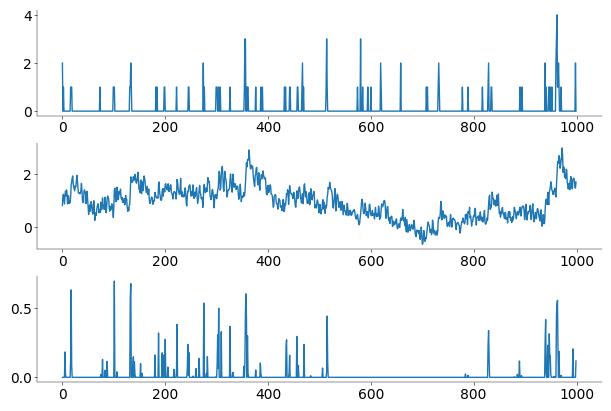

In [134]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
axs[0].plot(ogb_spikes_25["5"][:1000])
axs[1].plot(ogb_calcium_25["5"][:1000])
axs[2].plot(thing[0][:1000])
plt.show()

In [135]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------
thing = oopsi.fast(F=gcamp_calcium_25["6"], iter_max=10)

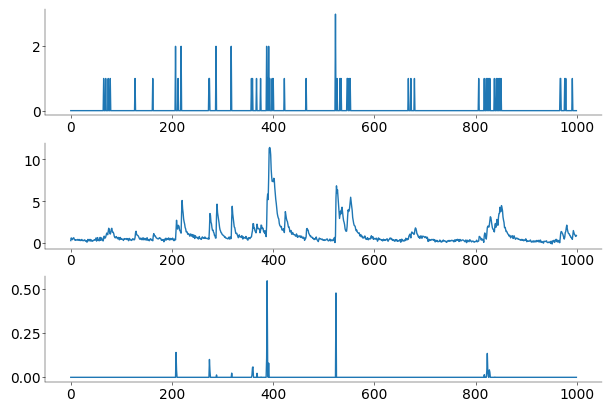

In [136]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)


# GCamP Cell
axs[0].plot(gcamp_spikes_25["6"][:1000])
axs[1].plot(gcamp_calcium_25["6"][:1000])
axs[2].plot(thing[0][:1000])
plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [ ]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

Combine both dataframes and plot

In [ ]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------